In [0]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd /content/gdrive/My Drive/tensorflow/models/research/object_detection

/content/gdrive/My Drive/tensorflow/models/research/object_detection


In [0]:
base_dir = 'colab_images'

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 128

#Rescaling image tensor

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

#Train generator

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

#Validation generator

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2796 images belonging to 26 classes.
Found 686 images belonging to 26 classes.


In [0]:
#Sizes of image and label batch

for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((128, 224, 224, 3), (128, 26))

In [0]:
#Printing classes

print (train_generator.class_indices)

#Writing label file

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'DTH22': 0, 'LED': 1, 'MPU6050_SENSOR': 2, 'arduino_mega': 3, 'arduino_nano': 4, 'arduino_uno': 5, 'buzzer': 6, 'camera': 7, 'cartridge-fuse': 8, 'clip-lead': 9, 'filament': 10, 'flame_sensor': 11, 'induction-coil': 12, 'ir_sensor_module': 13, 'lpg_gas_sensor_module': 14, 'memory-chip': 15, 'moisture_sensor': 16, 'multiplexer': 17, 'potentiometer': 18, 'pulse-generator': 19, 'raspberry_pi': 20, 'relay': 21, 'shunt': 22, 'stabilizer': 23, 'transistor': 24, 'ultrasonic sensor': 25}


In [0]:
#File for storing labels

!cat labels.txt

DTH22
LED
MPU6050_SENSOR
arduino_mega
arduino_nano
arduino_uno
buzzer
camera
cartridge-fuse
clip-lead
filament
flame_sensor
induction-coil
ir_sensor_module
lpg_gas_sensor_module
memory-chip
moisture_sensor
multiplexer
potentiometer
pulse-generator
raspberry_pi
relay
shunt
stabilizer
transistor
ultrasonic sensor

In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Here we are downloading MobileNetV2 as our base model

#Not including the top layer (i.e classification layer)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
#import for earlystopping

from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [0]:
#Declaring the base model non trainable as we intend to use the features it has already learned

base_model.trainable = False

In [0]:
#Adding our own layer to the base layer

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(26, activation='softmax')
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
#Summary of final model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 26)                858       
Total params: 2,627,514
Trainable params: 369,530
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [0]:
epochs = 40

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),callbacks=[early_stop])       
#callback function to prevent overfitting

Epoch 1/40
22/22 [==============================] - 1097s 50s/step - loss: 2.7263 - accuracy: 0.2450 - val_loss: 1.9445 - val_accuracy: 0.4286
Epoch 2/40
22/22 [==============================] - 14s 641ms/step - loss: 1.5744 - accuracy: 0.5222 - val_loss: 1.2623 - val_accuracy: 0.6297
Epoch 3/40
22/22 [==============================] - 14s 650ms/step - loss: 0.9862 - accuracy: 0.6949 - val_loss: 0.9186 - val_accuracy: 0.7362
Epoch 4/40
22/22 [==============================] - 14s 645ms/step - loss: 0.5681 - accuracy: 0.8469 - val_loss: 0.7093 - val_accuracy: 0.8090
Epoch 5/40
22/22 [==============================] - 14s 657ms/step - loss: 0.3588 - accuracy: 0.9052 - val_loss: 0.5208 - val_accuracy: 0.8557
Epoch 6/40
22/22 [==============================] - 14s 656ms/step - loss: 0.2524 - accuracy: 0.9374 - val_loss: 0.5764 - val_accuracy: 0.8367
Epoch 7/40
22/22 [==============================] - 14s 632ms/step - loss: 0.1774 - accuracy: 0.9574 - val_loss: 0.5366 - val_accuracy: 0.8542

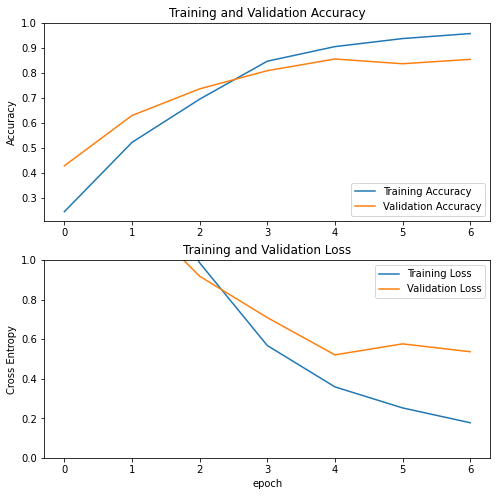

In [0]:
#Plotting graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
base_model.trainable = True

In [0]:
# Number of layers in base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
#Compiling

model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [0]:
#Summary of final model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 26)                858       
Total params: 2,627,514
Trainable params: 2,232,122
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
#Number of trainable layers

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [0]:
#Training

history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=45, 
                         validation_data=val_generator, 
                        validation_steps=len(val_generator),callbacks=[early_stop])

Epoch 1/45
22/22 [==============================] - 15s 693ms/step - loss: 1.0179 - accuracy: 0.7307 - val_loss: 0.5145 - val_accuracy: 0.8673
Epoch 2/45
22/22 [==============================] - 14s 654ms/step - loss: 0.5790 - accuracy: 0.8301 - val_loss: 0.5571 - val_accuracy: 0.8673
Epoch 3/45
22/22 [==============================] - 14s 622ms/step - loss: 0.4489 - accuracy: 0.8670 - val_loss: 0.5493 - val_accuracy: 0.8601


In [0]:
#Saving the model

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

#Converting the model to tflite for using it in android devices

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/fine_tuning/assets


INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [0]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

MessageError: ignored